In [1]:
# reset variables
%reset -f

## Import libraries

In [2]:
import gc 
import os

import datetime

from IPython.display import clear_output
from IPython.core.magic import register_cell_magic

import numpy as np
from numpy import zeros, ones
from numpy.random import randn, randint

from matplotlib import pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import telegram_send

import warnings
warnings.filterwarnings("ignore")

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
# cell magic function to write contents of a cell to file
# and run it afterwards so %%writefile wont run cell

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

### Setup folder structure

In [5]:
# images dataset location
dataset_dir = '../datasets/lfw-funneled [faces]'

# model and results will be stored under this name
now = datetime.datetime.now()
now = f'{str(now.date())}-{str(now.hour)}-{str(now.minute)}'
experiment_name = 'exp_' + now

# create folders to store models and training results
experiment_dir = f'./experiments/{experiment_name}/'
images_dir = f'./experiments/{experiment_name}/images/'
animations_dir = './animations/'
results_dir = './results/'

if not os.path.exists(experiment_dir): os.makedirs(experiment_dir)
if not os.path.exists(images_dir): os.makedirs(images_dir)
if not os.path.exists(animations_dir): os.makedirs(animations_dir)
if not os.path.exists(results_dir): os.makedirs(results_dir)

# files to save models creation parameters
hyperparameters_text = experiment_dir + 'hyperparameters.txt'
discriminator_text = experiment_dir + 'discriminator.txt'
generator_text = experiment_dir + 'generator.txt'
gan_text = experiment_dir + 'gan.txt'


### Hyperparameters

In [6]:
%%write_and_run $hyperparameters_text

# architecture
image_size = 128 # size of squared image 
latent_dim = 100 # generator seed size

dis_complex = 16 # discriminator complexity (number of filters)
dis_blocks = [2,2,2,2,2] 

gen_complex = 16 # generator complexity (number of filters) 
gen_blocks = [2,2,2,2,2]

leaky_relu_rate = 0.2
dropout_rate = 0.2
bn_momentum = 0.8

# training
n_epochs = 400  
n_batch = 64
d_learning_rate = 0.0003
g_learning_rate = 0.0002
beta_1=0.5


### Dataset loader

Found 5051 images belonging to 1 classes.


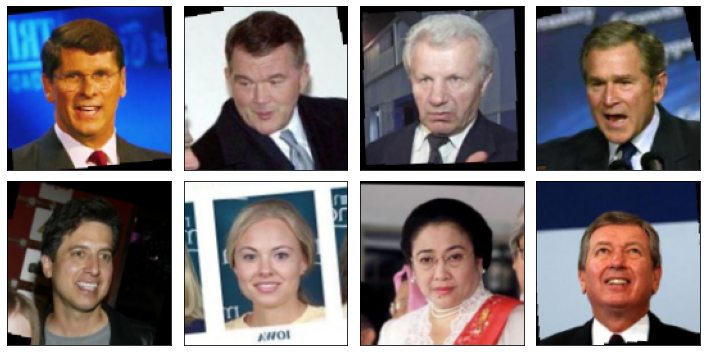

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

datagen = ImageDataGenerator(rescale=1/255., 
                             horizontal_flip=True, 
                             rotation_range=10
                            ) 

train_datagen_flow = datagen.flow_from_directory( 
    directory=dataset_dir,  
    target_size=(image_size, image_size),
    batch_size=16, 
    class_mode=None,  
    shuffle=True,
    keep_aspect_ratio=True)

data = next(train_datagen_flow)

# print sample images
fig = plt.figure(figsize=(10,5))
for i in range(8):
    fig.add_subplot(2, 4, i+1)
    plt.imshow((data[i]* 255).astype(np.uint8))

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Discriminator model

#### **ResNet**

In [ ]:
def lrelu_drop(inputs: tf.Tensor) ->  tf.Tensor:
    x = layers.Dropout(dropout_rate)(inputs)
    x = layers.LeakyReLU(alpha=leaky_relu_rate)(x)
    #x = layers.BatchNormalization()(x)

    return x

def residual_block_downsampled(x:  tf.Tensor, 
                               downsample: bool, 
                               filters: int, 
                               kernel_size: int = 3) ->  tf.Tensor:
    
    y = layers.Conv2D(kernel_size=kernel_size,
                      strides=(1 if not downsample else 2),
                      filters=filters,
                      padding="same")(x)
    y = lrelu_drop(y)
    y = layers.Conv2D(kernel_size=kernel_size,
                      strides=1,
                      filters=filters,
                      padding="same")(y)

    if downsample:
        x = layers.Conv2D(kernel_size=1,
                          strides=2,
                          filters=filters,
                          padding="same")(x)
    out = layers.Add()([x, y])
    out = lrelu_drop(out)
    return out 

def define_discriminator_resnet():
    num_blocks_list = dis_blocks
    num_filters = dis_complex
    
    
    # Head
    inputs = layers.Input(shape=(image_size,image_size,3))
    x = layers.GaussianNoise(stddev=0.2)(inputs)
    
    # Blocks
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            x = residual_block_downsampled(x, 
                                           downsample=(j==0), 
                                           filters=num_filters)
        num_filters *= 2
        
    # Tail
    x = layers.Conv2D(1, 3, 1, padding='same')(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
            
    model = keras.Model(inputs, outputs, name='Discriminator')

    #compile model
    opt = Adam(learning_rate=d_learning_rate, beta_1=beta_1)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model 


test_model = define_discriminator_resnet()
print(test_model.summary())
del test_model

### Generator model

In [ ]:
%%write_and_run $generator_text 

def define_generator(): 
    init_w = keras.initializers.RandomNormal(mean=0.0, stddev=0.02) # kernel_initializer
    
    res = 5  
    
    model = Sequential(
        [
            layers.Reshape((1,1,latent_dim), input_shape=(latent_dim,)),
            layers.Conv2DTranspose(gen_complex*32, 4, 4, padding='same'),
            layers.BatchNormalization(momentum=bn_momentum),
            layers.ReLU(),

            layers.Conv2DTranspose(gen_complex*16, res, 2, padding='same'),
            layers.BatchNormalization(momentum=bn_momentum),
            layers.ReLU(),
            
            layers.Conv2DTranspose(gen_complex*8, res, 2, padding='same'),
            layers.BatchNormalization(momentum=bn_momentum),
            layers.ReLU(),
            
            layers.Conv2DTranspose(gen_complex*4, res, 2, padding='same'),
            layers.BatchNormalization(momentum=bn_momentum),
            layers.ReLU(),
       
            layers.Conv2DTranspose(gen_complex*2, res, 2, padding='same'),
            layers.BatchNormalization(momentum=bn_momentum),
            layers.ReLU(),
            
            layers.Conv2DTranspose(gen_complex, res, 2, padding='same'),
            layers.BatchNormalization(momentum=bn_momentum),
            layers.ReLU(),

            layers.Conv2D(3, res, strides=1, padding='same', activation='tanh'),      
    
        ], name='generator'
    )
    
    return model
       
# model not compiled due to it is not trained directly like descriminator
# generator is trained via GAN combined model
 
test_model = define_generator()
print(test_model.summary())
del test_model

### GAN model

In [12]:
%%write_and_run $gan_text 

# Define the combined generator and disriminator model for updating the generator
# Discriminator is trained separately so here only generator will be trained
# by keeping the discriminator constant

def define_gan(generator, discriminator):
    discriminator.trainable = False # discriminator is trained separately
    
# connect generator and discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
# compile model
    opt = Adam(learning_rate=g_learning_rate, beta_1=beta_1)
    model.compile(loss='binary_crossentropy', optimizer=opt)  
    
    return model

### Sample generators

In [ ]:
def generate_real_samples(datagenflow, n_samples):
    datagenflow.batch_size = n_samples
    X = next(datagenflow)
    y = ones((X.shape[0],1))
    
    X = X.astype('float32')
    X = (X - 0.5) / 0.5 #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
    
    return X,y

In [14]:
def generate_latent_points(latent_dim, n_samples, seed=None):
    np.random.seed(seed)
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

In [15]:
def generate_fake_samples(generator, latent_dim, n_samples, yrange=(0,0), seed=None):
    if n_samples == 0:
        return (None, None)
    x_input = generate_latent_points(latent_dim, n_samples, seed)
    X = generator.predict(x_input, verbose=0)
    #y = zeros((n_samples,1))
    y = np.random.uniform(low=yrange[0], high=yrange[1], size=(X.shape[0],1))
    
    return X,y

In [16]:
def show_samples(samples):
    n_samples = samples.shape[0]
    samples = (samples + 1) / 2.0

    grid = int(np.ceil(n_samples ** 0.5))
    fig = plt.figure(figsize=(10,10))
    for i in range (n_samples):
        plt.subplot(grid, grid, i+1)
        plt.axis('off')
        plt.imshow(samples[i])
    plt.show()

In [18]:
def plot_and_save_images(generated_images, 
                         folder_name, 
                         title, 
                         cols, 
                         rows, 
                         figsize, 
                         show=False, 
                         subtitles=False):
    
    fig, axs = plt.subplots(rows, cols, constrained_layout=True)
    fig.set_figheight(figsize[0])
    fig.set_figwidth(figsize[1])
    for i in range(rows):
        for j in range(cols):
            axs[i][j].imshow(generated_images[i][j], interpolation='nearest', cmap='gray_r')
            axs[i][j].axis('off')
            #if not subtitles is None:
            #    if i == 0 and j == 0:
            #        axs[i][j].set_title(subtitles[0], fontsize=10)
            #    if i == int(rows/2) and j == 0:
            #        axs[i][j].set_title(subtitles[1], fontsize=10)
    
    fig.suptitle(title, fontsize=12)
    plt.savefig(os.path.join(folder_name, title + '.png'))
    if show:
        plt.show()
    plt.close()


def plot_generated_images(images, 
                          folder_name, 
                          title, 
                          cols=4, 
                          rows=4, 
                          figsize=(10, 10), 
                          show=False, 
                          subtitles=('generated', 'dataset')):
    
    #generated_images = generator.predict(noise)
    #images = np.concatenate([images, PICS_FROM_DATASET[0]])
    images = (images + 1 ) / 2
    images = images.reshape(rows, cols, image_size, image_size,3)
    plot_and_save_images(images, folder_name, title, cols, rows, figsize, show, subtitles)
    

### Train routine function

In [19]:
def train(experiment_name, g_model, d_model, gan_model, 
          datagenflow, latent_dim, n_epochs=100, n_batch=128, 
          draw_period = 1, save_period = 50):
   
    # number of batches per one epoch
    bat_per_epo = int(np.ceil(datagenflow.samples / n_batch))
    
    # the discriminartor model for a half batch of real samples 
    half_batch = int(n_batch / 2) 
    
    # data for diagrams
    d_loss_hist = []
    g_loss_hist = []
 
    for i in range(n_epochs): # enumerate epochs
        d_loss_epoch = 0
        g_loss_epoch = 0
        
        for j in range(bat_per_epo): # enumarate batches
            
            # train discriminator on real samples
            X_real, y_real = generate_real_samples(datagenflow, half_batch) # get some real images
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) # update D weights on real images

            # train discriminator on fake samples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch) 
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake) # update D weights on fake images

            # train generator
            g_loss=0
            if i>1:
                X_gan = generate_latent_points(latent_dim, n_batch, None) # input for the generator
                y_gan = ones((n_batch,1)) # label generate images to trick the discriminator
                g_loss = gan_model.train_on_batch(X_gan, y_gan)
 
            # summarize batch losses
            d_loss_epoch += d_loss_real+d_loss_fake #d_loss_hist.append(d_loss_real+d_loss_fake)
            g_loss_epoch += g_loss #g_loss_hist.append(g_loss)
            
            print('.', end='')
 
        # save models
        if not (i+1) % save_period:
            g_model.save(experiment_dir + '/' + experiment_name + '_gen')
            d_model.save(experiment_dir + '/' + experiment_name + '_dis')
            gan_model.save(experiment_dir + '/' + experiment_name + '_gan')
        
        # save average batch loss of epoch
        d_loss_hist.append(d_loss_epoch/bat_per_epo)
        g_loss_hist.append(g_loss_epoch/bat_per_epo)
        
        # show images and loss history diagram
        if not i % draw_period or i == n_epochs-1:
            images = generate_fake_samples(g_model , latent_dim, 16, yrange=(0,0), seed=12345)[0]
            clear_output() 
            print('Epoch>%d, Batch %d/%d, d_loss_real=%.5f, d_loss_fake=%.5f, g_loss=%.5f' % 
                (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
                 
            title = experiment_name +"_{:0>4}".format(i)
            plot_generated_images(images, images_dir, title, show=True) 
            
            ax = plt.figure(figsize=(10, 5))
            plt.yscale('log')
            #plt.ylim(0, 5)
            plt.plot(d_loss_hist)
            plt.plot(g_loss_hist)
            plt.title('Average loss per epoch')
            plt.legend(['Discriminator loss', 'Generator loss'])
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.show()
            
        # clear memory
        keras.backend.clear_session() 
        gc.collect()
        
    # сохраним финальный результат в корневую папку
    images = generate_fake_samples(generator , latent_dim, 16, yrange=(0,0), seed=12345)[0]
    plot_generated_images(images, results_dir, experiment_name +'_final', show=False) 
    

### Run training

In [20]:
try:
    generator = keras.models.load_model(experiment_dir + 'generator_model')
    discriminator = keras.models.load_model(experiment_dir + 'discriminator_model')
    gan_model = keras.models.load_model(experiment_dir + 'gan_model')
    print('Models loaded.')
except:
    discriminator = define_discriminator_resnet() # define_discriminator()
    generator = define_generator() # define_generator_resnet()
    gan_model = define_gan(generator, discriminator)
    print('New models created.')

New models created.


In [ ]:
draw_period = 5  # number of epochs between redraw 
save_period = 50  # number of epochs between saving backup

# run training routine
train(experiment_name, generator, discriminator, gan_model, 
      train_datagen_flow, latent_dim, n_epochs=n_epochs, n_batch=n_batch,
      draw_period=draw_period,save_period=save_period
     ) 

# send telegram message after training
# message includes generated image sample
with open( f'{results_dir}{experiment_name}_final.png', "rb") as f:
    telegram_send.send(images=[f], messages=[experiment_name + " finished!"])

## Save gif animation

In [25]:
import imageio.v2 as imageio
import tqdm
import sys
import os
from IPython.display import Image

path = images_dir
filename = animations_dir + experiment_name + '_animation.gif'

included_extensions = ["png"]
all_pics_filenames = [fn for fn in os.listdir(path) if any(fn.endswith(ext) for ext in included_extensions)]
all_pics_filenames.sort()
 
with imageio.get_writer(filename, mode='I', fps=2) as writer:
    
    for i in tqdm.tqdm(
            range(len(all_pics_filenames)),
            file=sys.stdout, 
            colour = 'GREEN', 
            position=0, 
            leave=True):
        
        image = imageio.imread(os.path.join(path, all_pics_filenames[i]))
        writer.append_data(image)

100%|██████████| 81/81 [00:02<00:00, 34.80it/s]


## Show results

1/1 [==============================] - 0s 153ms/step


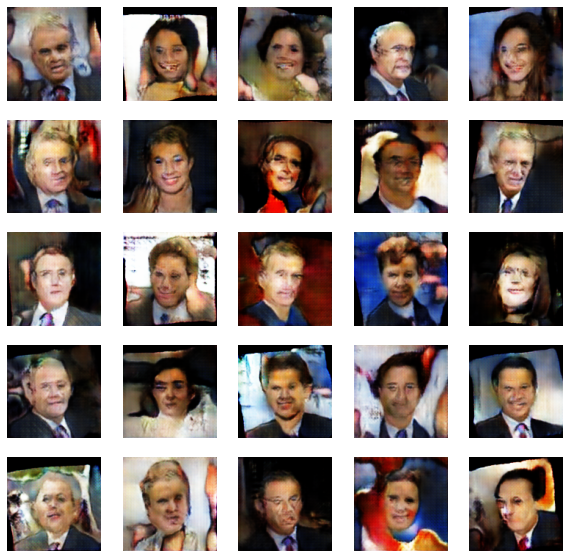

In [27]:
from keras.models import load_model
import numpy as np
from numpy.random import randn
from matplotlib import pyplot as plt

generator = load_model(experiment_dir + experiment_name + '_gen')

latent_points = generate_latent_points(100,25)
X = generator.predict(latent_points)

show_samples(X)